<a href="https://colab.research.google.com/github/balcomes/keras-autoencoders/blob/master/StyleSandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import imageio
import time

from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K

from scipy.optimize import fmin_l_bfgs_b

target_image_path = 'sprite.png'
style_reference_image_path = 'dwarves.png'
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

print('Model loaded.')

def content_loss(base, combination):
  return K.sum(K.square(combination - base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
  a = K.square(x[:,:img_height-1,:img_width-1,:] - x[:,1:,:img_width-1,:])
  b = K.square(x[:,:img_height-1,:img_width-1,:] - x[:,:img_height-1,1:,:])
  return K.sum(K.pow(a + b, 1.25))

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(target_image_features,
                                      combination_features)

for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator = Evaluator()

result_prefix = 'my_result'
iterations = 20
x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                   x,
                                   fprime=evaluator.grads,
                                   maxfun=20)
  print('Current loss value:', min_val)
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  imageio.imwrite(fname, img)
  print('Image saved as', fname)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

In [0]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist

from scipy.stats import norm

#z_mean, z_log_variance = encoder(input_img)
#z = z_mean + exp(z_log_variance) * epsilon
#reconstructed_img = decoder(z)
#model = Model(input_img, reconstructed_img)

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same',
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same',
                  activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0],
                                   latent_dim), mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)

x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

class CustomVariationalLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(
    1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

y = CustomVariationalLayer()([input_img, z_decoded])

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train,
        y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()


In [0]:
import keras
import numpy as np
import os
from keras import layers
from keras.preprocessing import image

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = keras.models.Model(generator_input, x)
generator.summary()

discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008,
                                                   clipvalue=1.0,
                                                   decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape((x_train.shape[0],) +
                          (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = ''
start = 0

for step in range(iterations):
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
  generated_images = generator.predict(random_latent_vectors)
  stop = start + batch_size
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])
  labels = np.concatenate([np.ones((batch_size, 1)),
                           np.zeros((batch_size, 1))])
  labels += 0.05 * np.random.random(labels.shape)
  d_loss = discriminator.train_on_batch(combined_images, labels)
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
  misleading_targets = np.zeros((batch_size, 1))
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
  start += batch_size

  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')
    print('discriminator loss:', d_loss)
    print('adversarial loss:', a_loss)
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
    img = image.array_to_img(real_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

In [3]:
import autogluon as ag
from autogluon import TabularPrediction as task

train_data = task.Dataset(file_path =
              'https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')

# subsample 500 data points for faster demo
train_data = train_data.head(500)
print(train_data.head())

label_column = 'class'
print("Summary of class variable: \n", train_data[label_column].describe())

dir = 'agModels-predictClass'

# specifies folder where to store trained models
predictor = task.fit(train_data = train_data,
                     label = label_column,
                     output_directory = dir)

test_data = task.Dataset(file_path =
              'https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')

# values to predict
y_test = test_data[label_column]

# delete label column to prove we're not cheating
test_data_nolab = test_data.drop(labels = [label_column], axis = 1)
print(test_data_nolab.head())

# unnecessary, just demonstrates how to load
# previously-trained predictor from file

#predictor = task.load(dir) 

y_pred = predictor.predict(test_data_nolab)
print("Predictions:  ", y_pred)
perf = predictor.evaluate_predictions(y_true = y_test,
                                      y_pred = y_pred,
                                      auxiliary_metrics = True)

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv | Columns = 15 / 15 | Rows = 39073 -> 39073
Beginning AutoGluon training ...
AutoGluon will save models to agModels-predictClass/
Train Data Rows:    500
Train Data Columns: 15
Preprocessing data ...
Here are the first 10 unique label values in your data:  [' <=50K' ' >50K']
AutoGluon infers your prediction problem is: binary  (because only two unique label-values observed)
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
Feature Generator processed 500 data points with 14 features
Original Features:
	int features: 6
	object features: 8
Generated Features:
	int features: 0
All Features:
	int features: 6
	object features: 8
	Data preprocessing and feature engineering runtime = 0.11s ...
AutoGluon will gauge predictive performance using ev

   age   workclass  fnlwgt  ... hours-per-week  native-country   class
0   25     Private  178478  ...             40   United-States   <=50K
1   23   State-gov   61743  ...             35   United-States   <=50K
2   46     Private  376789  ...             15   United-States   <=50K
3   55           ?  200235  ...             50   United-States    >50K
4   36     Private  224541  ...             40     El-Salvador   <=50K

[5 rows x 15 columns]
Summary of class variable: 
 count        500
unique         2
top        <=50K
freq         394
Name: class, dtype: object


	0.89	 = Validation accuracy score
	0.65s	 = Training runtime
	0.12s	 = Validation runtime
Fitting model: RandomForestClassifierEntr ...
	0.9	 = Validation accuracy score
	0.64s	 = Training runtime
	0.12s	 = Validation runtime
Fitting model: ExtraTreesClassifierGini ...
	0.86	 = Validation accuracy score
	0.53s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesClassifierEntr ...
	0.86	 = Validation accuracy score
	0.52s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: KNeighborsClassifierUnif ...
	0.8	 = Validation accuracy score
	0.01s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: KNeighborsClassifierDist ...
	0.77	 = Validation accuracy score
	0.02s	 = Training runtime
	0.11s	 = Validation runtime
Fitting model: LightGBMClassifier ...
	0.88	 = Validation accuracy score
	0.34s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: CatboostClassifier ...
	0.9	 = Validation accuracy score
	0.87s	 = Training runtime
	0.01s

   age          workclass  fnlwgt  ... capital-loss  hours-per-week  native-country
0   31            Private  169085  ...            0              20   United-States
1   17   Self-emp-not-inc  226203  ...            0              45   United-States
2   47            Private   54260  ...         1887              60   United-States
3   21            Private  176262  ...            0              30   United-States
4   17            Private  241185  ...            0              20   United-States

[5 rows x 14 columns]


Evaluation: accuracy on test data: 0.825366


Predictions:   [' <=50K' ' <=50K' ' <=50K' ... ' <=50K' ' <=50K' ' <=50K']


Evaluations on test data:
{
    "accuracy": 0.8253659535264612,
    "accuracy_score": 0.8253659535264612,
    "balanced_accuracy_score": 0.6880318396555511,
    "matthews_corrcoef": 0.46129936504568697,
    "f1_score": 0.8253659535264612
}
Detailed (per-class) classification report:
{
    " <=50K": {
        "precision": 0.8418421992145663,
        "recall": 0.9494027647295665,
        "f1-score": 0.892393086918128,
        "support": 7451
    },
    " >50K": {
        "precision": 0.7240117130307467,
        "recall": 0.4266609145815358,
        "f1-score": 0.5369163952225842,
        "support": 2318
    },
    "accuracy": 0.8253659535264612,
    "macro avg": {
        "precision": 0.7829269561226565,
        "recall": 0.6880318396555511,
        "f1-score": 0.7146547410703561,
        "support": 9769
    },
    "weighted avg": {
        "precision": 0.8138832405725258,
        "recall": 0.8253659535264612,
        "f1-score": 0.8080451524979959,
        "support": 9769
    }
}


In [0]:
predictor = task.fit(train_data = task.Dataset(file_path = <file-name>),
                     label_column = <variable-name>)

results = predictor.fit_summary()

print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon categorized the features as: ", predictor.feature_types)

age_column = 'age'
print("Summary of age variable: \n", train_data[age_column].describe())

predictor_age = task.fit(train_data = train_data,
                         output_directory = "agModels-predictAge",
                         label = age_column)

performance = predictor_age.evaluate(test_data)

In [4]:
#!pip install imageio
#!pip install --upgrade mxnet
#!pip install autogluon

#!pip install distributed==1.23.3
#!pip install dask==0.19.4
#!pip install tornado==4.5.1

#!pip install quandl

#WARNING: Upgrading ipython, ipykernel, tornado, prompt-toolkit or pyzmq can
#cause your runtime to repeatedly crash or behave in unexpected ways and is not
#recommended. If your runtime won't connect or execute code, you can reset it
#with "Factory reset runtime" from the "Runtime" menu.
#WARNING: tornado > 4.5.0 is incompatible with ipykernel < 5.0
#WARNING: The following packages were previously imported in this runtime:
#  [PIL,tornado,tqdm]
#Run "pip install -U ipykernel" before restarting to avoid repeated crashes.

  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6077 sha256=e3ed5d405b577569bf90c9c8f376a85fecb573716548c431058c3ccd264e0091
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection


In [0]:
import quandl
#quandl.save_key("supersecret")
#print(quandl.ApiConfig.api_key)
#quandl.read_key()

In [0]:
data1 = quandl.get('NSE/OIL')
data2 = quandl.get_table('ZACKS/FC', ticker='AAPL')

In [8]:
data1

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2009-09-30,1096.00,1156.70,1090.00,1135.00,1141.20,19748012.0,223877.07
2009-10-01,1102.00,1173.70,1102.00,1167.00,1166.35,3074254.0,35463.78
2009-10-05,1152.00,1165.90,1136.60,1143.00,1140.55,919832.0,10581.13
2009-10-06,1149.80,1157.20,1132.10,1143.30,1144.90,627957.0,7185.90
2009-10-07,1153.80,1160.70,1140.00,1141.45,1141.60,698216.0,8032.98
...,...,...,...,...,...,...,...
2018-12-31,178.10,179.00,174.35,175.00,174.80,761462.0,1343.75
2019-01-01,175.00,176.40,174.15,175.15,175.75,381570.0,669.16
2019-01-02,175.80,176.20,171.00,172.35,172.40,722532.0,1251.85


In [21]:
data2

,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_end_date,per_type,per_code,per_fisc_year,per_fisc_qtr,per_cal_year,per_cal_qtr,data_type_ind,filing_type,qtr_nbr,zacks_sector_code,zacks_x_ind_code,zacks_metrics_ind_code,fye_month,comp_cik,per_len,sic_code,filing_date,last_changed_date,state_incorp_name,bus_address_line_1,bus_city,bus_state_name,bus_post_code,bus_phone_nbr,bus_fax_nbr,mail_address_line_1,mail_city,mail_state_name,mail_post_code,country_name,country_code,home_exchange_name,emp_cnt,...,change_asset_liab,tot_change_asset_liab,oper_activity_other,cash_flow_oper_activity,net_change_prop_plant_equip,net_change_intang_asset,net_acq_divst,net_change_sterm_invst,net_change_lterm_invst,net_change_invst_tot,invst_activity_other,cash_flow_invst_activity,net_lterm_debt,net_curr_debt,debt_issue_retire_net_tot,net_comm_equity_issued_repurch,net_pref_equity_issued_repurch,net_tot_equity_issued_repurch,tot_comm_pref_stock_div_paid,fin_activity_other,cash_flow_fin_activity,fgn_exchange_rate_adj,disc_oper_misc_cash_flow_adj,incr_decr_cash,beg_cash,end_cash,stock_based_compsn,comm_stock_div_paid,pref_stock_div_paid,tot_deprec_amort_qd,stock_based_compsn_qd,cash_flow_oper_activity_qd,net_change_prop_plant_equip_qd,comm_stock_div_paid_qd,pref_stock_div_paid_qd,tot_comm_pref_stock_div_qd,wavg_shares_out,wavg_shares_out_diluted,eps_basic_net,eps_diluted_net
None,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,AAPL,AAPL,APPLE INC,Apple Inc.,NSDQ,USD,2018-09-30,A,None,2018,4,2018,3,F,10-K,2018,10,199,9,9,0000320193,12,3571,2018-11-05,2018-11-05,CA,ONE APPLE PARK WAY,CUPERTINO,CA,95014,408-996-1010,None,ONE APPLE PARK WAY,CUPERTINO,CA,95014,UNITED STATES,X1,None,132000.0,...,30013.0,34694.0,None,77434.0,-13313.0,None,-721.0,32363.0,-1518.0,30845.0,-745.0,16066.0,469.0,-37.0,432.0,-72069.0,None,-72069.0,-13712.0,-2527.0,-87876.0,None,None,5624.0,20289.0,25913.0,5340.0,-13712.0,None,NaN,NaN,NaN,NaN,NaN,None,NaN,4955.377,5000.109,12.01,11.91
1,AAPL,AAPL,APPLE INC,Apple Inc.,NSDQ,USD,2018-03-31,Q,None,2018,2,2018,1,F,10-Q,201802,10,199,9,9,0000320193,3,3571,2018-05-02,2018-05-02,CA,ONE APPLE PARK WAY,CUPERTINO,CA,95014,408-996-1010,None,ONE APPLE PARK WAY,CUPERTINO,CA,95014,UNITED STATES,X1,None,NaN,...,47082.0,35794.0,None,43423.0,-7005.0,None,-305.0,22377.0,-163.0,22214.0,216.0,15120.0,6469.0,NaN,6469.0,-32524.0,None,-32524.0,-6529.0,-1189.0,-33773.0,None,None,24770.0,20289.0,45059.0,2644.0,-6529.0,None,2739.0,1348.0,15130.0,-4195.0,-3190.0,None,-3190.0,5024.877,5068.493,2.75,2.73
2,AAPL,AAPL,APPLE INC,Apple Inc.,NSDQ,USD,2018-06-30,Q,None,2018,3,2018,2,F,10-Q,201803,10,199,9,9,0000320193,3,3571,2018-08-01,2018-08-01,CA,ONE APPLE PARK WAY,CUPERTINO,CA,95014,408-996-1010,None,ONE APPLE PARK WAY,CUPERTINO,CA,95014,UNITED STATES,X1,None,NaN,...,41648.0,33880.0,None,57911.0,-10272.0,None,-431.0,31771.0,-1478.0,30293.0,-523.0,19067.0,469.0,-10.0,459.0,-53306.0,None,-53306.0,-10182.0,-2267.0,-65296.0,None,None,11682.0,20289.0,31971.0,3995.0,-10182.0,None,2665.0,1351.0,14488.0,-3267.0,-3653.0,None,-3653.0,4882.167,4926.609,2.36,2.34
3,AAPL,AAPL,APPLE INC,Apple Inc.,NSDQ,USD,2018-09-30,Q,None,2018,4,2018,3,F,10-Q,201804,10,199,9,9,0000320193,3,3571,2018-11-05,2018-11-05,CA,ONE APPLE PARK WAY,CUPERTINO,CA,95014,408-996-1010,None,ONE APPLE PARK WAY,CUPERTINO,CA,95014,UNITED STATES,X1,None,132000.0,...,30013.0,34694.0,None,77434.0,-13313.0,None,-721.0,32363.0,-1518.0,30845.0,-745.0,16066.0,469.0,-37.0,432.0,-72069.0,None,-72069.0,-13712.0,-2527.0,-87876.0,None,None,5624.0,20289.0,25913.0,5340.0,-13712.0,None,2754.0,1345.0,19523.0,-3041.0,-3530.0,None,-3530.0,4955.377,5000.109,2.98,2.95
4,AAPL,AAPL,APPLE INC,Apple Inc.,NSDQ,USD,2018-12-31,Q,None,2019,1,2018,4,F,10-Q,201901,10,199,9,9,0000320193,3,3571,2019-01-30,2019-01-30,CA,ONE APPLE PARK WAY,CUPERTINO,CA,95014,408-996-1010,None,ONE APPLE PARK WAY,CUPERTINO,CA,95014,UNITED STATES,X1,None,NaN,...,6219.0,1772.0,None,26690.0,-3355.0,None,-167.0,9849.0

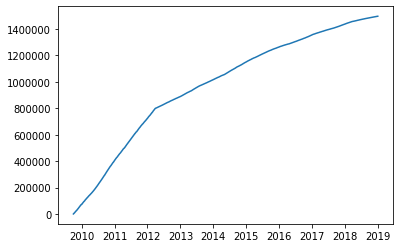

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.lineplot(data = data1["Close"].cumsum())

In [39]:
#!pip install pyEDM

     |████████████████████████████████| 5.1MB 2.8MB/s 
     |████████████████████████████████| 153kB 30.2MB/s 


EmbedDimension( dataFrame = sampleData["TentMap"], lib = "1 100", pred = "201 500", columns = "TentMap", target = "TentMap") 



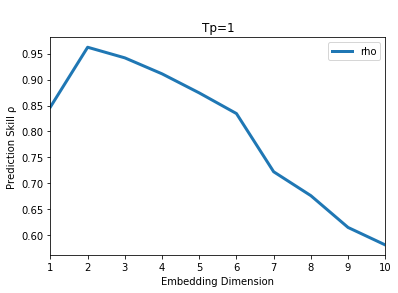

PredictInterval( dataFrame = sampleData["TentMap"], lib = "1 100", pred = "201 500", E = 2, columns = "TentMap", target = "TentMap") 



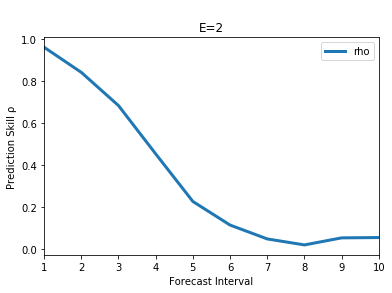

PredictNonlinear( dataFrame = sampleData["TentMapNoise"], lib = "1 100", pred = "201 500", E = 2, columns = "TentMap", target = "TentMap" ) 



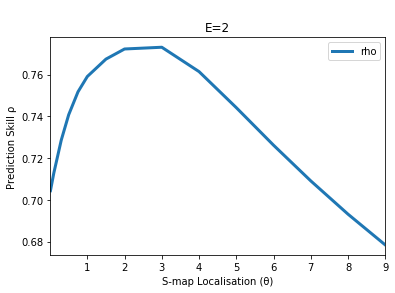

Simplex( dataFrame = sampleData["block_3sp"], lib = "1 99", pred = "100 195",  E = 3, embedded = True, showPlot = True, const_pred = True, columns="x_t y_t z_t", target="x_t") 



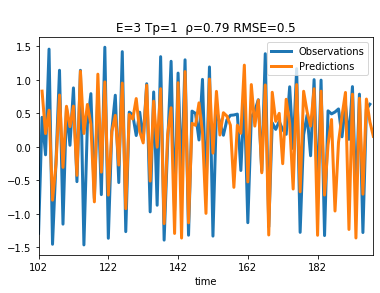

Simplex( dataFrame = sampleData["block_3sp"], lib = "1 99", pred = "105 190",  E = 3, showPlot = True, const_pred = True, columns = "x_t", target = "x_t") 



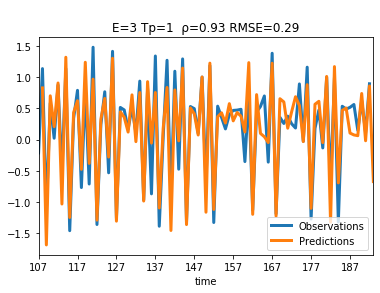

Multiview( dataFrame = sampleData["block_3sp"], lib = "1 99", pred = "105 190",  E = 3, columns = "x_t y_t z_t", target = "x_t", showPlot = True) 



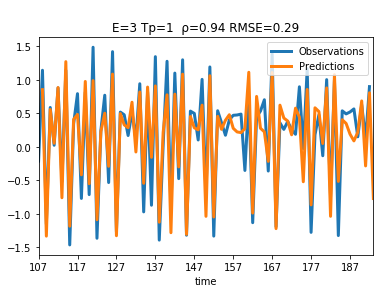

SMap( dataFrame = sampleData["circle"], lib = "1 100", pred = "110 190", theta = 4, E = 2, verbose = True, showPlot = True, embedded = True, columns = "x y", target = "x") 



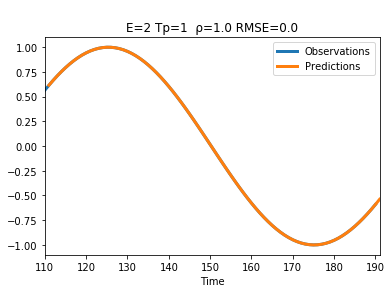

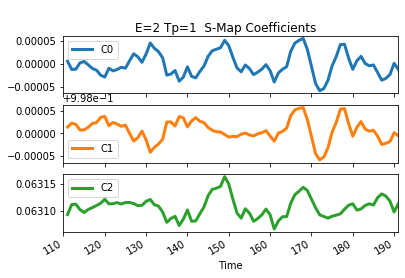

CCM( dataFrame = sampleData["sardine_anchovy_sst"], E = 3, Tp = 0, columns = "anchovy", target = "np_sst", libSizes = "10 70 10", sample = 100, verbose = True,  showPlot = True) 



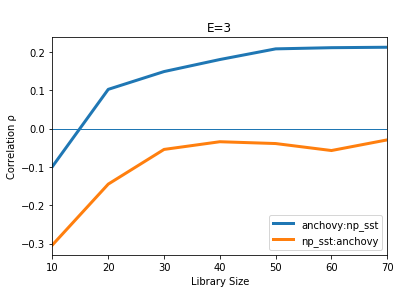

In [40]:
import pyEDM
pyEDM.Examples()

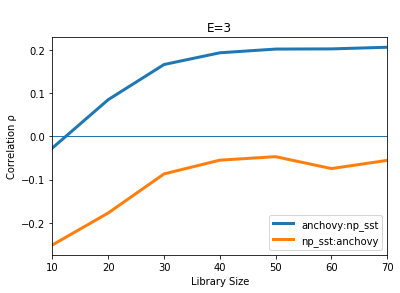

,LibSize,anchovy:np_sst,np_sst:anchovy
0,10.0,-0.026564,-0.251190
1,20.0,0.085246,-0.177185
2,30.0,0.166595,-0.086743
3,40.0,0.193757,-0.054924
4,50.0,0.202357,-0.046856
5,60.0,0.202775,-0.074415
6,70.0,0.206583,-0.055389


In [44]:
pyEDM.CCM(dataFrame = pyEDM.sampleData["sardine_anchovy_sst"],
          E = 3,
          Tp = 0,
          columns = "anchovy",
          target = "np_sst",
          libSizes = "10 70 10",
          sample = 100,
          verbose = True,
          showPlot = True)

In [43]:
pyEDM.sampleData

{'TentMap':      Time  TentMap
 0       1 -0.09920
 1       2 -0.60130
 2       3  0.79980
 3       4 -0.79441
 4       5  0.79800
 ..    ...      ...
 994   995 -0.69848
 995   996  0.77053
 996   997 -1.20288
 997   998  0.91498
 998   999  0.16928
 
 [999 rows x 2 columns], 'TentMapNoise':      Time  TentMap
 0       1  0.07284
 1       2 -0.51930
 2       3  0.68247
 3       4 -0.99431
 4       5  0.81873
 ..    ...      ...
 994   995 -0.65294
 995   996  0.76480
 996   997 -1.12111
 997   998  0.97377
 998   999  0.10209
 
 [999 rows x 2 columns], 'block_3sp':      time       x_t     x_t-1     x_t-2  ...     y_t-2       z_t     z_t-1     z_t-2
 0       3 -1.917685  1.244882 -0.741863  ... -1.268104  1.535239 -0.481583 -1.863980
 1       4 -0.962318 -1.917685  1.244882  ...  1.488887 -1.492956  1.535239 -0.481583
 2       5  1.331875 -0.962318 -1.917685  ... -0.113188 -1.119476 -1.492956  1.535239
 3       6 -0.817083  1.331875 -0.962318  ... -1.106779  0.746658 -1.119476 -1.49295